In [1]:
import glob
import segyio
import segysak
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from devito import configuration, VectorTimeFunction, TensorTimeFunction
from examples.seismic import AcquisitionGeometry, plot_velocity
from examples.seismic.elastic import ElasticWaveSolver
from scratch.util import CreateSeismicModel, nn_interp_coords, plot_rec_src, plot_seis_data, plot_rec_src

In [2]:
configuration['ignore-unknowns'] = True

In [3]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [4]:
sc_path = 'Modeling_data/2D_Scenarios'
scenarios = glob.glob(sc_path+'/Scenario*')

df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
# df_ins['X'] = np.linspace(0,7950, 319)

constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

In [5]:
def surface_indecies(arr, axis=1, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)


In [6]:
for i, scenario in enumerate(scenarios[:1]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185},
                                         segyio_kwargs={'endian' : 'little'}
                                        )
    el_pars = {file.split('/')[-1].split('_')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    for k, v in el_pars.items():
        el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки
    
    cdp_x = el_pars['Vp'].cdp_x.to_numpy()
    cdp_y = el_pars['Vp'].cdp_y.to_numpy()
    el_pars['x'] = np.cumsum(np.sqrt(np.diff(cdp_x[:, 0], prepend=cdp_x[0, 0])**2+np.diff(cdp_y[:, 0], prepend=cdp_y[0, 0])**2))/10
    el_pars['z'] = el_pars['Rho'].samples.data
    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    # Верхний слой со свойствами воды
    # rho_data[rho_data==0] = 1.
    vp_data[vp_data==0] = 0.330
    vs_data[vs_data==0] = 0.0

    # сетка
    dim_vectors = (el_pars['x'], el_pars['z'])
    spacing = (2.5, 2.5) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
    origin = (0, 0)
    nbl = 40
    so = 8
    
    # инт данные
    rho_data_int = nn_interp_coords(rho_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)
    vp_data_int = nn_interp_coords(vp_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)
    vs_data_int = nn_interp_coords(vs_data, origin, (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)

    depth = surface_indecies(arr = vs_data)*2

    # rho_data_int = rho_data_int[:, np.max(depth):]
    # vs_data_int = vs_data_int[:, np.max(depth):]
    # vp_data_int = vp_data_int[:, np.max(depth):]

    # модель
    model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='mask',
                          )
    
    # геометрия
    t0=0.
    tn=2000.
    f0=0.025

    # nsrc = 2
    # src_coordinates = np.empty((nsrc, 2))
    # src_coordinates[:] = ((df_ins['X'][159], 0), (df_ins['X'][100], 0))
    
    nsrc = 245
    src_coordinates = np.empty((nsrc, 2))
    src_coordinates[:, 0] = np.arange(1000,7125, 25)
    src_coordinates[:, 1] = df_ins['Z'][142]
    src_coordinates = src_coordinates[122:123, :]

    interpolator = interp1d(el_pars['x'], surface_indecies(arr = vs_data), kind = 'nearest')

    nrec = int(el_pars['x'].max()/5) #df_ins.shape[0]
    rec_coordinates = np.empty((nrec, 2))
    rec_coordinates[:,0] = np.arange(0, int(el_pars['x'].max()), 5) #df_ins['X']
    rec_coordinates[:,1] = interpolator(rec_coordinates[:, 0])*2 #df_ins['Z']
    
    # тензоры
    v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)
    tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=2)

    print('Starting operator')
    for i, src_coords in enumerate(tqdm(src_coordinates)):
        print('Source - ', i, '; Coordinate - ', src_coords)
        geometry = AcquisitionGeometry(model, rec_coordinates, src_coords, t0, tn, f0=f0, src_type='Ricker')
        
        # солвер
        solver = ElasticWaveSolver(model, geometry, space_order=so, v=v, tau=tau)
        
        # оператор
        rec_p, rec_v, v, tau, summary = solver.forward()
        
        # выгрузка в sgy
        dt_r = 0.5
        # inheader = segysak.segy.segy_header_scrape(scenario+'/Vs_smooth_2D')
        rec_v = rec_v.resample(dt=dt_r)
        
        segyio.tools.from_array2D(scenario+'/Results/2d_vankor_SRC-'+str(int(src_coords[0]))+'.sgy', rec_v.data.T, dt=dt_r*10**3)
        with segyio.open(scenario+'/Results/2d_vankor_SRC-'+str(int(src_coords[0]))+'.sgy', 'r+') as f:
            for j in range(len(f.header)):
                f.header[j] = {segyio.TraceField.SourceGroupScalar : -100,
                               segyio.TraceField.SourceX : int(src_coords[0]*100),
                               segyio.TraceField.GroupX : np.array(rec_v.coordinates.data[j,0], dtype = int)
                    # segyio.TraceField.CDP: j,
                    #            segyio.TraceField.CDP_X: np.array(inheader['CDP_X'][j]*10),
                    #            segyio.TraceField.CDP_Y: np.array(inheader['CDP_Y'][j]*10),
                               # segyio.TraceField.ReceiverGroupElevation: np.array(df_ins['Z'][j], dtype = int),
                               # segyio.TraceField.ElevationScalar : 1,
                               
                            
                            
                              }
        #Доделать, чтобы шот отображался еще и в названии

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Operator `initdamp` ran in 0.07 s


Starting operator


  0%|          | 0/1 [00:00<?, ?it/s]

Source -  0 ; Coordinate -  [4050.   64.]


Operator `ForwardElastic` ran in 2.59 s
/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


In [7]:
def plot_seis_data(rec_coordinates, rec_data, t0: float, tn: float, gain = 2e2):
    #NBVAL_SKIP
    # Pressure (txx + tzz) data at sea surface
    extent = [rec_coordinates[0, 0], rec_coordinates[-1, 0], 1e-3*tn, t0]
    aspect = rec_coordinates[-1, 0]/(1e-3*tn)
    vminmax = np.max(np.abs(rec_data))
    sc = vminmax/gain
    plt.figure(figsize=(15, 15))
    plt.imshow(rec_data[::5,:], vmin=-sc, vmax=sc, cmap="seismic",
               interpolation='bilinear', extent=extent, aspect=aspect)
    plt.ylabel("Time (s)", fontsize=20)
    plt.xlabel("Receiver position (m)", fontsize=20)
    plt.show()

In [8]:
rec_v.data.shape

(4002, 1620)

In [9]:
boof = rec_v.data
for i in range(boof.shape[1]):
    boof[:, i] *= np.linspace(1,3, boof.shape[0])

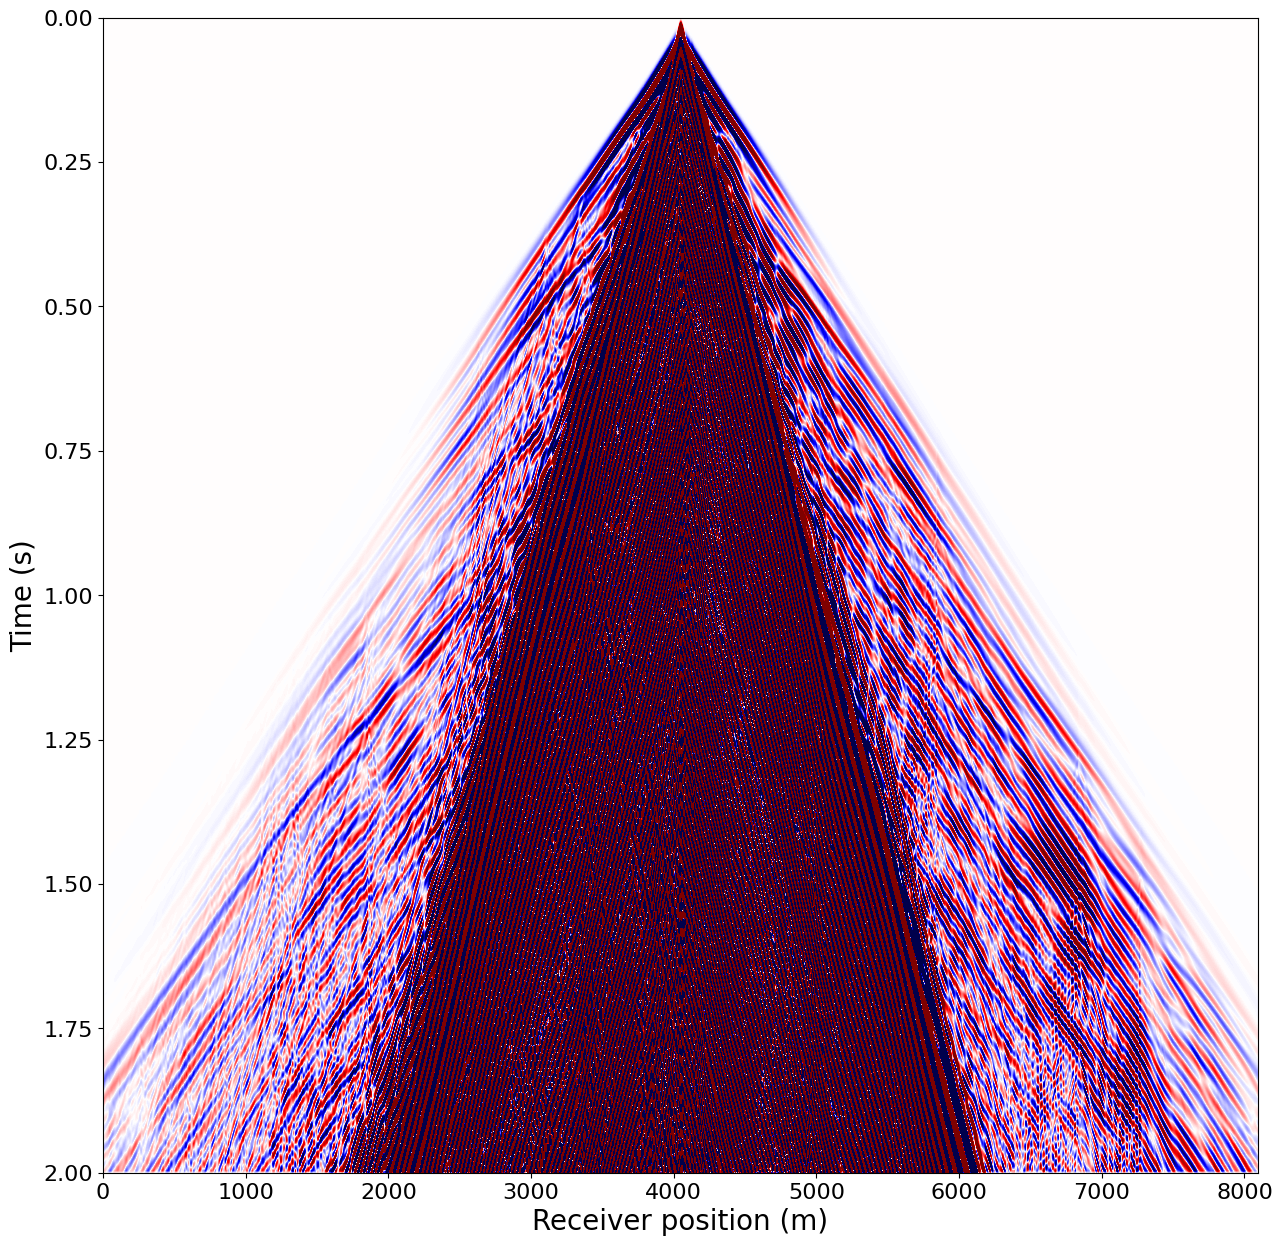

In [10]:
plot_seis_data(rec_v.coordinates.data, boof, t0=t0, tn=tn, gain=7e2)

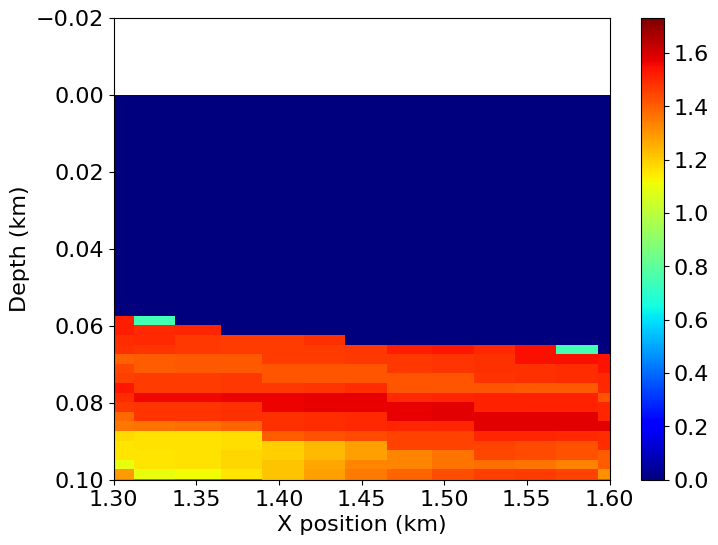

In [11]:
plot_rec_src(model=model, data_type='vs', src_coords=src_coordinates, rec_coords=rec_v.coordinates.data, yrange = (0.1, -0.02), xrange = (1.3,1.6))